### Criação do diretório para modelos
Nesta etapa é criado um diretório para armazenar os modelos treinados e checkpoints gerados durante o treinamento da rede neural.

In [41]:
#cria a pasta para armazenar o checkpoint e os modelos treinados
import os
os.makedirs("models", exist_ok=True)

### Importação das bibliotecas
Nesta seção são importadas as bibliotecas utilizadas para manipulação de dados, visualização gráfica, pré-processamento, construção e treinamento da rede neural LSTM.


In [42]:
#Bibliotecas para manipulação de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# Deep Learning com Keras
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM,Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#bibliotecas para plotar graficos do keras
import pydot as pyd
tensorflow.keras.utils.pydot = pyd

### Importação e pré-processamento inicial dos dados
Nesta etapa o dataset de temperatura e umidade é importado, as colunas relevantes são selecionadas e os dados são convertidos para os tipos adequados. A coluna de data é utilizada como índice temporal da série.


In [43]:
col_names = ['estacao','data','hora','tempmax','urm','']

# importação de dados
data = pd.read_csv('dataset/temperatura.csv', header=0, names=col_names, sep=';')

# Remoção de colunas não utilizadas
data = data.drop(['estacao', 'hora', ''], axis=1)

# Conversão de tipos
data['tempmax'] = data['tempmax'].astype("float32")
data['urm'] = data['urm'].astype("float32")
data['data'] = pd.to_datetime(data['data'], dayfirst=True, errors='coerce')

# Nomeando Colunas
x1_names = 'tempmax'
x2_names = 'urm'

# Ajuste do índice temporal
data.set_index('data', inplace=True)
data.sort_index(inplace=True)

# Separação das séries
serie1 = data['tempmax'].values.reshape(-1, 1)
serie2 = data['urm'].values.reshape(-1, 1)

print(serie1.shape)
print(serie2.shape)
print(data.head())

(2172, 1)
(2172, 1)
              tempmax    urm
data                        
2011-01-01  24.400000  89.50
2011-01-02  24.799999  90.25
2011-01-03  26.400000  93.75
2011-01-04  25.600000  89.50
2011-01-05  28.600000  89.50


## Definição de parâmetros

Nesta etapa são definidos os principais parâmetros utilizados no pré-processamento
dos dados e na configuração do modelo LSTM.


In [44]:
# Parâmetros de pré-processamento e modelo
norm_method = 'none'        # Método de normalização log, asinh e none.
range_adjust = (0,1)        # Intervalo para normalização
new_model = False           # Indica se um novo modelo será treinado
size_hist_window = 30       # Tamanho da janela de entrada
size_forw_window = 10       # Tamanho da janela de saída
model_name = 'lstm_temperatura.keras'
data_adjust_exec = True     # Executa tratamento dos dados
export_frames = True        # Exporta datasets tratados

## Análise temporal por ano

Visualização da evolução da temperatura máxima e da umidade relativa do ar,
segmentadas por ano, para identificação de padrões sazonais.


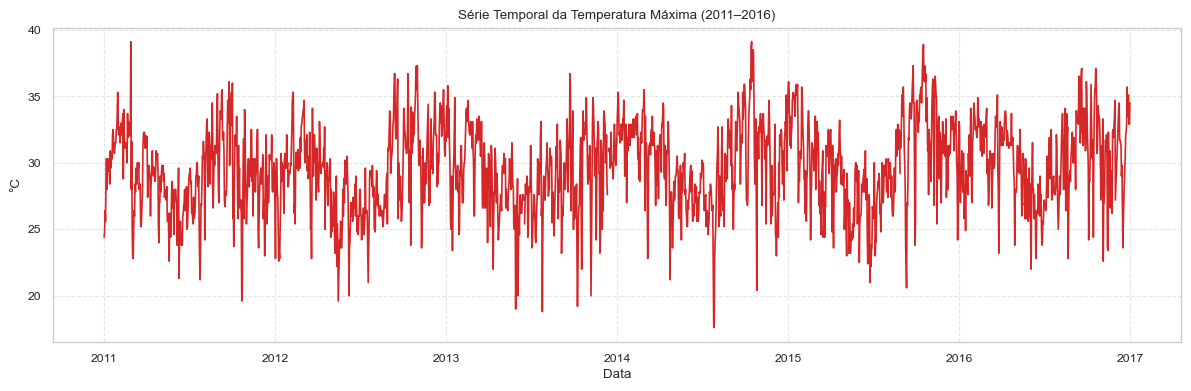

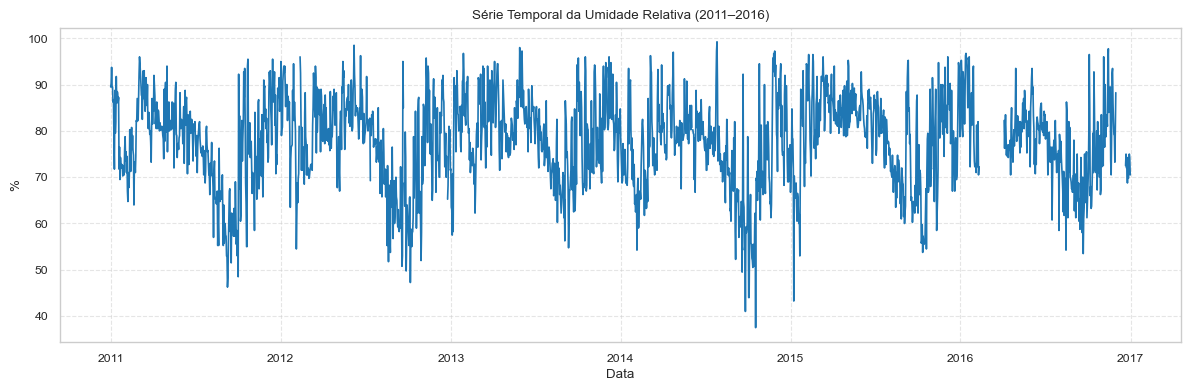

In [45]:
# Identifica os anos presentes nos dados
anos = data.index.year.unique()

# Plot da série temporal completa - Temperatura máxima
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['tempmax'], color='tab:red')
plt.title("Série Temporal da Temperatura Máxima (2011–2016)")
plt.ylabel("°C")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot da série temporal completa - Umidade relativa
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['urm'], color='tab:blue')
plt.title("Série Temporal da Umidade Relativa (2011–2016)")
plt.ylabel("%")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Distribuição das variáveis

Histogramas das séries de temperatura máxima e umidade relativa do ar.


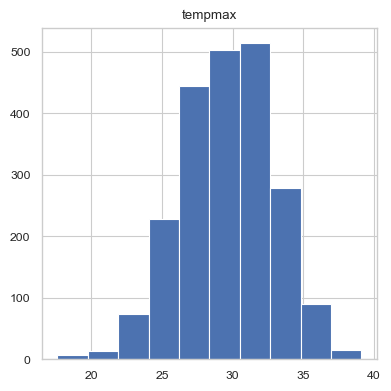

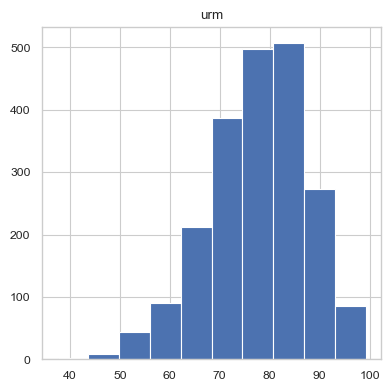

In [46]:
# Histograma da temperatura máxima
data.hist(column=x1_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

# Histograma da umidade relativa
data.hist(column=x2_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

## Medidas de dispersão e outliers

Boxplots das séries de temperatura máxima e umidade relativa do ar.


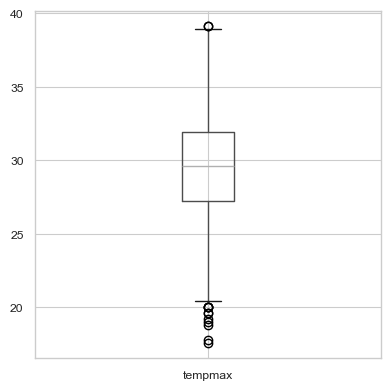

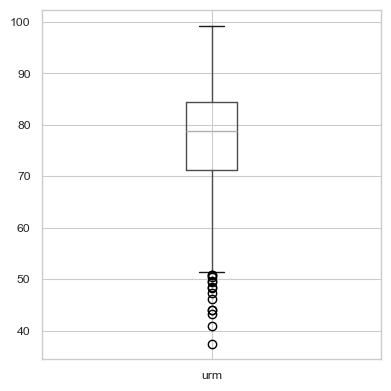

In [47]:
# Boxplot da temperatura máxima
data.boxplot(column=x1_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

# Boxplot da umidade relativa
data.boxplot(column=x2_names, figsize=(4, 4))
plt.tight_layout()
plt.show()

## Verificação de dados faltantes

Avaliação da presença de valores ausentes nas séries analisadas.


In [48]:
# Verificação de valores ausentes
missing_counts = data.isnull().sum()
print("Total de dados faltantes por atributo:")
print(missing_counts)

Total de dados faltantes por atributo:
tempmax     3
urm        65
dtype: int64


## Tratamento de dados faltantes

Aplicação de interpolação para correção de valores ausentes nas séries de entrada,
quando necessário.


In [49]:
# Interpolação de valores faltantes nas séries
x_names = ['tempmax', 'urm']

def interpolacao(data):
    # Verifica se existem valores ausentes
    if data.isnull().values.any():
        # Índices críticos (início e fim da série)
        points_inds_danger = [0, 1, len(data) - 2, len(data) - 1]
        for colname in x_names:
            # Tratamento de valores ausentes nas extremidades
            for ind_danger in points_inds_danger:
                if np.isnan(data[colname].iloc[ind_danger].astype(float)):
                    data[colname].iloc[ind_danger] = data[colname].mean()
            # Interpolação dos valores intermediários
            data[colname] = data[colname].interpolate(method='nearest').copy()
    return data

In [50]:
#Aplicação da interpolação
data = interpolacao(data)
serie1 = data['tempmax'].values.reshape(-1, 1)
serie2 = data['urm'].values.reshape(-1, 1)

## Estabilização de variância

Definição de funções para aplicação e inversão de transformações de estabilização
de variância nas séries temporais.


In [51]:
# Funções para estabilização e inversão da variância
def varianceEstabilization(serie, method):
    if method == 'asinh':
        return np.arcsinh(serie)
    elif method == 'log':
        return np.log(serie)
    else:
        return serie
    
def inverseVarianceEstabilization(serie, method):
    if method == 'asinh':
        return np.sinh(serie)
    elif method == 'log':
        return np.exp(serie)
    else:
        return serie

## Normalização das séries

Aplicação de normalização nas séries de temperatura máxima e umidade relativa,
visando adequação ao treinamento da rede neural.


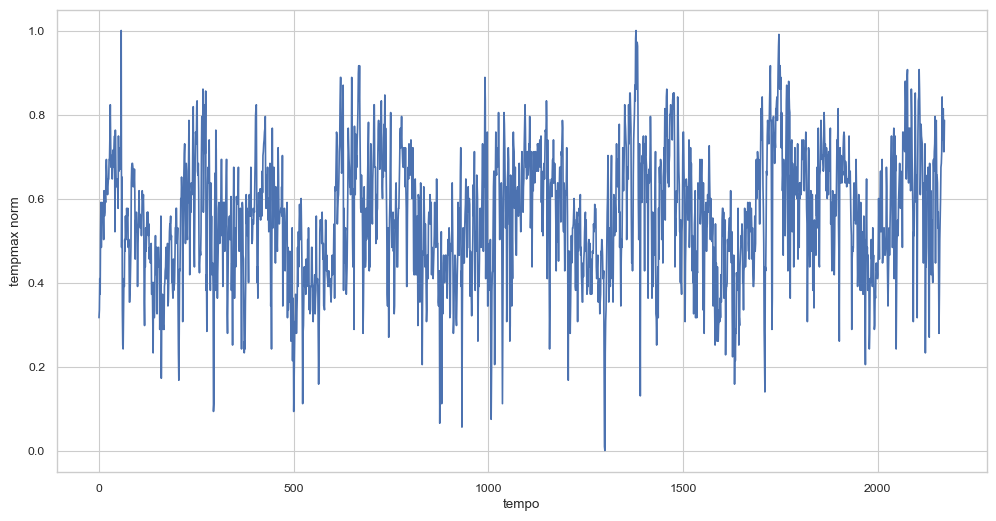

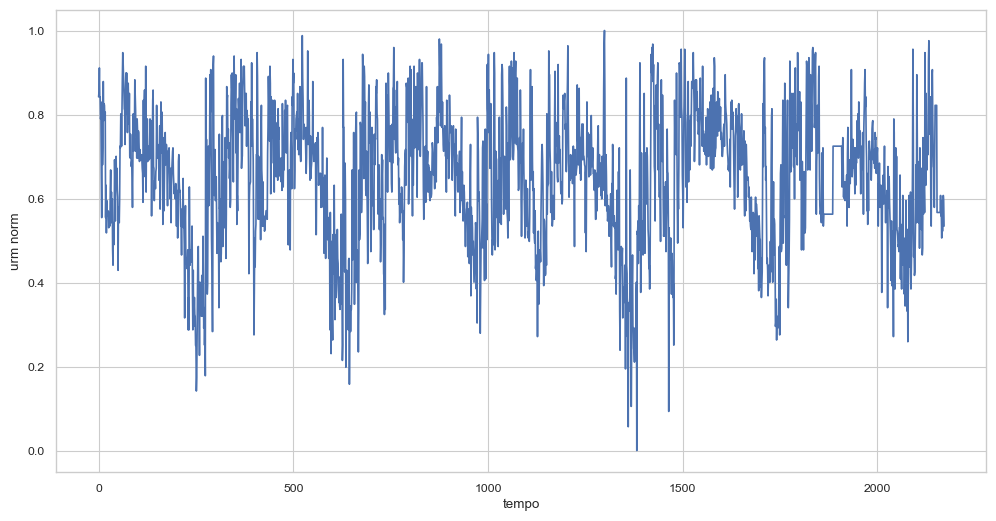

In [52]:
# Ajuste e normalização dos dados
if data_adjust_exec:
    serie1 = varianceEstabilization(serie1, norm_method)
    scaler1 = MinMaxScaler(feature_range=range_adjust)
    serie1 = scaler1.fit_transform(serie1)

    serie2 = varianceEstabilization(serie2, norm_method)
    scaler2 = MinMaxScaler(feature_range=range_adjust)
    serie2 = scaler2.fit_transform(serie2)

# Visualização das séries normalizadas
plt.plot(serie1)
plt.xlabel("tempo")
plt.ylabel(x1_names + " norm")
plt.show()

plt.plot(serie2)
plt.xlabel("tempo")
plt.ylabel(x2_names + " norm")
plt.show()

## Separação dos conjuntos de dados

Divisão do dataset em conjuntos de treino, validação e teste conforme o período
definido no enunciado da atividade.


In [53]:
# Separação dos dados
train_df = data[:'2015-06-30']
val_df   = data['2015-07-01':'2015-12-31']
test_df  = data['2016-01-01':'2016-12-31']

print(f"Linhas - Treino: {len(train_df)}, Validação: {len(val_df)}, Teste: {len(test_df)}")

# Função para normalização utilizando os scalers já ajustados
def prepare_data(df, scaler_temp, scaler_urm):
    # Temperatura
    temp = df['tempmax'].values.reshape(-1, 1)
    temp = varianceEstabilization(temp, norm_method)
    temp = scaler_temp.transform(temp) # IMPORTANTE: Usar 'transform', não 'fit'
    
    # Umidade
    urm = df['urm'].values.reshape(-1, 1)
    urm = varianceEstabilization(urm, norm_method)
    urm = scaler_urm.transform(urm)
    
    # Concatenação das variáveis de entrada
    return np.hstack((temp, urm))

# Aplicação da transformação
train_dataset = prepare_data(train_df, scaler1, scaler2)
val_dataset   = prepare_data(val_df,   scaler1, scaler2)
test_dataset  = prepare_data(test_df,  scaler1, scaler2)

print(f"Shape final Treino: {train_dataset.shape}") # Deve ser (N, 2)

Linhas - Treino: 1638, Validação: 184, Teste: 350
Shape final Treino: (1638, 2)


## Janelamento móvel

Criação dos padrões de entrada e saída utilizando janelas deslizantes,
considerando dados históricos de temperatura e umidade para prever
a temperatura futura.


In [54]:
# Cria os frames (Sliding Window)
def create_frames(serie, back_window_size, forw_window_size):
    x_frames, y_frames = [], []
    
    # Limite para evitar extrapolação da série
    limit = len(serie) - back_window_size - forw_window_size + 1
    
    for i in range(limit):
        # Entrada: histórico de temperatura e umidade
        x_frames.append(serie[i:(i + back_window_size), :])
        
        # Saída: temperatura futura
        y_frames.append(serie[(i + back_window_size):(i + back_window_size) + forw_window_size, 0])
        
    return np.array(x_frames), np.array(y_frames)

## Geração dos conjuntos de treino, validação e teste

Aplicação do janelamento móvel para criação dos conjuntos de entrada e saída
utilizados no treinamento e avaliação da rede LSTM.


In [55]:
# Criação dos frames para treino, validação e teste
x_train, y_train = create_frames(train_dataset, size_hist_window, size_forw_window)
x_val, y_val     = create_frames(val_dataset,   size_hist_window, size_forw_window)
x_test, y_test   = create_frames(test_dataset,  size_hist_window, size_forw_window)

# Verificação das dimensões
print(f"Treino: X={x_train.shape}, Y={y_train.shape}")
print(f"Valid.: X={x_val.shape},   Y={y_val.shape}")
print(f"Teste:  X={x_test.shape},  Y={y_test.shape}")

Treino: X=(1599, 30, 2), Y=(1599, 10)
Valid.: X=(145, 30, 2),   Y=(145, 10)
Teste:  X=(311, 30, 2),  Y=(311, 10)


## Definição da arquitetura LSTM

Construção de uma rede neural profunda utilizando camadas LSTM e camadas densas
para previsão da temperatura futura.


In [56]:
# Configurações de neurônios
units_lstm1 = 16
units_lstm2 = 32
units_lstm3 = 32
units_dense = 16
dropout_rate = 0.2

# Funções de ativação
actfunc_lstm1 = 'tanh'
actfunc_lstm2 = 'tanh'
actfunc_lstm3 = 'tanh'
actfunc_dense = 'tanh'
actfunc_output = 'linear'

#inicializador
initializer = tensorflow.keras.initializers.LecunNormal(seed=42)

# Criação das entradas de treino+validação
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]), name="x_train")

# Camada LSTM 1
layer_lstm1 = LSTM(units_lstm1, 
                    activation=actfunc_lstm1, 
                    return_sequences=True,
                    kernel_initializer=initializer)(inputs)
layer_drop1 = Dropout(dropout_rate)(layer_lstm1)

# Camada LSTM 2
layer_lstm2 = LSTM(units_lstm2, 
                    activation=actfunc_lstm2, 
                    return_sequences=True,
                    kernel_initializer=initializer)(layer_drop1)
layer_drop2 = Dropout(dropout_rate)(layer_lstm2)

# Camada LSTM 3
layer_lstm3 = Bidirectional(LSTM(units_lstm3, 
                                activation=actfunc_lstm3, 
                                return_sequences=False,
                                kernel_initializer=initializer))(layer_drop2)
layer_drop3 = Dropout(dropout_rate)(layer_lstm3)

# Camada densa final para ajustar o formato da saída
layer_dense = Dense(units_dense, activation=actfunc_dense)(layer_drop3)
layer_dense_out = Dense(y_train.shape[1], activation=actfunc_output)(layer_dense)

# Modelo final
model_trained = Model(inputs=inputs, outputs=layer_dense_out)

## Visualização da arquitetura do modelo

Apresentação do resumo textual e do diagrama da rede neural LSTM construída.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_train (InputLayer)        [(None, 30, 2)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 16)            1216      
                                                                 
 dropout_3 (Dropout)         (None, 30, 16)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 32)            6272      
                                                                 
 dropout_4 (Dropout)         (None, 30, 32)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                           

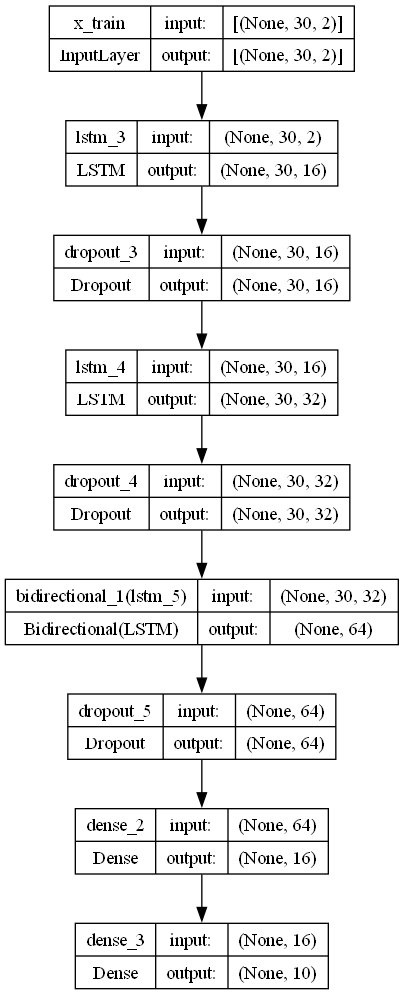

In [57]:
# Resumo do modelo
model_trained.summary()

# Diagrama da arquitetura
plot_model(
    model_trained, 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir="TB"
)

## Compilação e treinamento do modelo

Configuração da função de custo, otimizador, callbacks e execução do treinamento
da rede LSTM.


In [58]:
# Caminho para armazenamento do melhor modelo
checkpoint_path = "checkpoints/melhor_modelo" 

if new_model:
    print("Iniciando treinamento (Formato TF Nativo)...")
    
    # 1. Configuração do Checkpoint
    cp = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss', 
        mode='min', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    es = EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)

    # 2. Compilação
    opt = Adam(learning_rate=0.00001) 
    model_trained.compile(optimizer=opt, loss='mean_squared_error')

    # 3. Treinamento
    history = model_trained.fit(
        x_train, 
        y_train,
        validation_data=(x_val, y_val), 
        epochs=1000, 
        batch_size=32, 
        callbacks=[cp, es],
        verbose=1,
        shuffle=True
    )

    # Salvando histórico de treinamento
    np.save('history_temperatura.npy', history.history)
    print("Treinamento concluído!")

else:
    print(f"Carregando pesos...")
    try:
        model_trained.load_weights(checkpoint_path)
        print("Pesos carregados com sucesso!")
    except:
        print("Checkpoint não encontrado. Mude new_model=True.")

Carregando pesos...
Pesos carregados com sucesso!


## Curva de convergência

Evolução do erro quadrático médio durante o treinamento e validação do modelo.


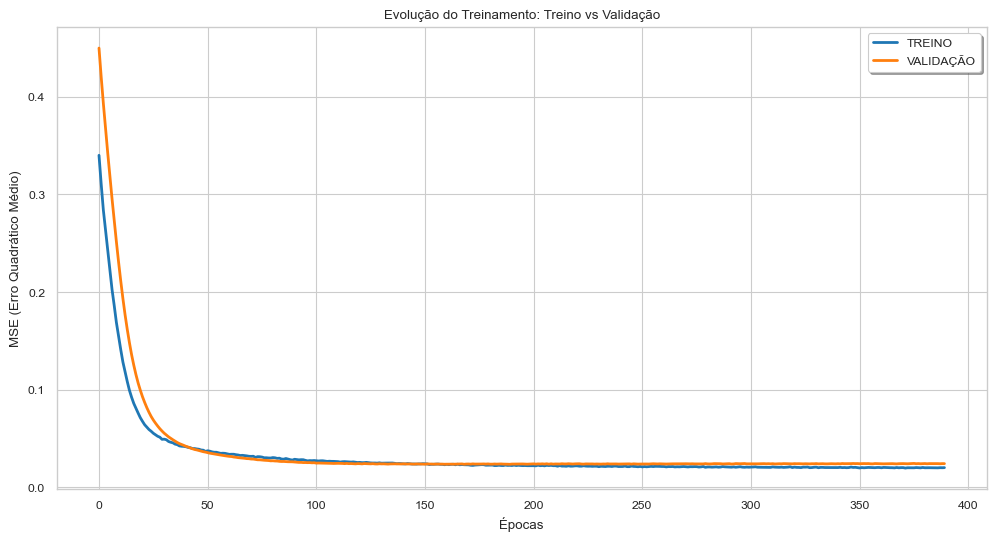

In [59]:
# Carregamento do histórico de treinamento
try:
    history_dict = np.load('history_temperatura.npy', allow_pickle=True).item()
except:
    # Se falhar o load (ou se você não salvou), tenta usar a variável da memória
    if 'history' in locals():
        history_dict = history.history
    else:
        print("Erro: Histórico não encontrado.")
        history_dict = {}

if history_dict:
    # Configurações visuais do Seaborn
    sns.set(rc={'figure.figsize':(12, 6)})
    sns.set_style('whitegrid')
    sns.set_context('paper')

    # Extrai os dados
    train_metric = history_dict['loss']
    valid_metric = history_dict['val_loss'] # Sempre temos validação neste projeto
    name_metric = 'MSE (Erro Quadrático Médio)'

    # Plotagem
    fig = plt.figure()
    plt.plot(train_metric, label='TREINO', color='#1f77b4', linewidth=2)
    plt.plot(valid_metric, label='VALIDAÇÃO', color='#ff7f0e', linewidth=2)
    plt.ylabel(name_metric)
    plt.xlabel('Épocas')
    plt.title('Evolução do Treinamento: Treino vs Validação')
    plt.legend(loc='upper right', fancybox=True, shadow=True)
    plt.show()

## Desnormalização das previsões

Conversão das previsões e dos valores reais para a escala original da temperatura,
permitindo avaliação adequada do desempenho do modelo.


In [60]:
# Previsões do modelo
predicted_data = model_trained.predict(x_test)

# Ajuste de formato para inversão da normalização
predicted_reshaped = predicted_data.reshape(predicted_data.flatten().shape[0], 1)

# Desnormalização das previsões
predicted_inv = scaler1.inverse_transform(predicted_reshaped)
predicted_final = inverseVarianceEstabilization(predicted_inv, norm_method).flatten()

# Valores reais
y_test_reshaped = y_test.reshape(y_test.flatten().shape[0], 1)

# Desnormalização dos valores reais
y_true = scaler1.inverse_transform(y_test_reshaped)
y_true = inverseVarianceEstabilization(y_true, norm_method).flatten()

# Verificação
print("Previsões desnormalizadas com sucesso!")
print(f"Shape dos Reais (y_true): {y_true.shape}")
print(f"Shape dos Previstos (predicted_final): {predicted_final.shape}")

10/10 [==============================] - 2s 8ms/step
Previsões desnormalizadas com sucesso!
Shape dos Reais (y_true): (3110,)
Shape dos Previstos (predicted_final): (3110,)


## Métricas de avaliação

Definição das métricas utilizadas para avaliar o desempenho preditivo do modelo.


In [61]:
# Erro percentual médio absoluto
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Impressão das métricas de regressão
def printRegressionMetrics(y_true, y_pred):
    MAPE = mape(y_true, y_pred)
    R2 = metrics.r2_score(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    print(f'MAPE: {MAPE:.2f}%')
    print(f'R2:   {R2:.4f}')
    print(f'MSE:  {MSE:.4f}')
    print(f'RMSE: {RMSE:.4f}')

## Avaliação do modelo no conjunto de teste

Cálculo das métricas de desempenho utilizando os dados reais e previstos do ano de 2016.


In [62]:
# Garante a compatibilidade: Se y_hat não existir, usa o predicted_final
if 'predicted_final' in locals():
    y_hat = predicted_final

# Calcula as métricas
print("--- Resultado Final (Teste 2016) ---")
printRegressionMetrics(y_true, y_hat)

--- Resultado Final (Teste 2016) ---
MAPE: 7.62%
R2:   0.1420
MSE:  7.8614
RMSE: 2.8038


## Reconstrução dos valores reais (treino + validação)

Preparação dos dados reais em escala original para análises comparativas.


In [63]:
# 1. Reconstrói o y_trainval juntando Treino e Validação
y_trainval = np.concatenate((y_train, y_val), axis=0)

# Ajuste de formato
y_true_trainval = y_trainval.flatten().reshape(-1, 1)

# Desnormalização
y_true_trainval = scaler1.inverse_transform(y_true_trainval)
y_true_trainval = inverseVarianceEstabilization(y_true_trainval, norm_method).flatten()

# Verificação
print("Histórico de Treino+Validação desnormalizado!")
print(f"Shape final: {y_true_trainval.shape}")

Histórico de Treino+Validação desnormalizado!
Shape final: (17440,)


In [64]:
df_forecast = pd.DataFrame({
    'y_true': y_true,
    'y_hat':  y_hat
})

df_forecast.shape

(3110, 2)

## Análise visual dos resultados
Comparação gráfica e análise estatística entre as previsões e os valores reais.


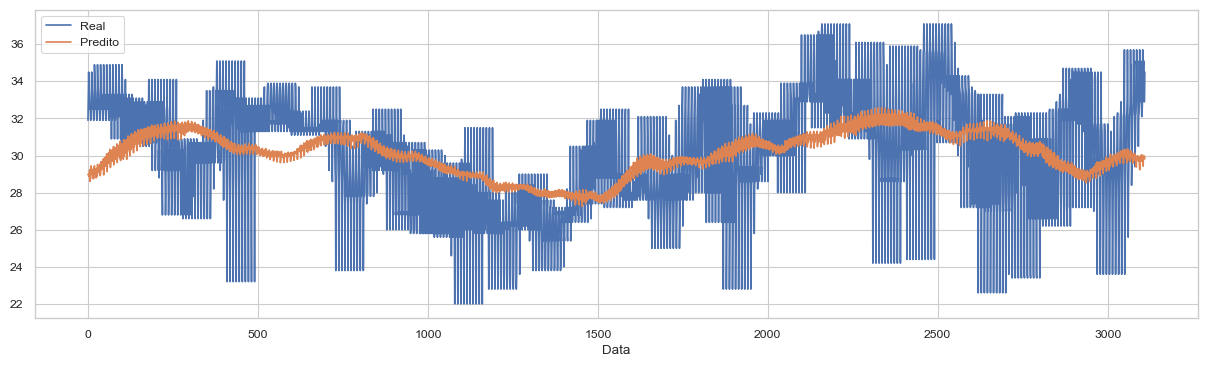

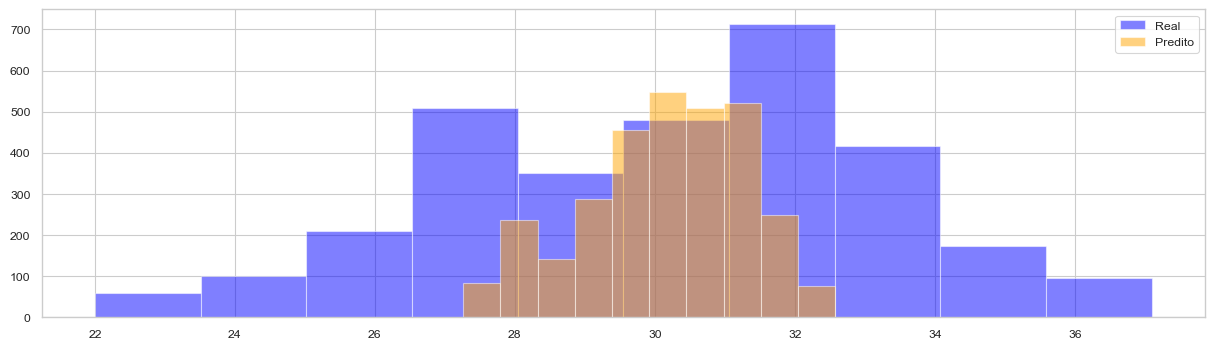

In [65]:
sns.set(rc={'figure.figsize':(15, 4)})
sns.set_style('whitegrid')
sns.set_context('paper')

ax = df_forecast.plot(x_compat=True, style='-')
ax.set_xlabel("Data")
ax.legend(["Real", "Predito"])
plt.grid(True)
plt.show()
plt.close()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')
plt.figure(figsize=(15, 4))
plt.hist(y_true, bins=10, color='blue', alpha=0.5, label='Real')
plt.hist(y_hat, bins=10, color='orange', alpha=0.5, label='Predito')
plt.legend()
plt.show()
plt.close()

## Considerações finais
Resultados obtidos a partir da aplicação do modelo LSTM no conjunto de teste.